In [1]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import cv2
import math
from tqdm import tqdm
from skimage.transform import resize
from scipy.interpolate import interpn
import pickle as pkl

In [2]:
img = np.rollaxis(np.array(tifffile.imread('Low concentration 1.tiff')), 0, 3)

In [3]:
def preprocess(img, n):
    N = math.floor(0.25 * img.shape[2] / (0.12*n))
    new_img = np.zeros((img.shape[0], img.shape[1], N))
    current = 0
    for k in range(N):
        interp = round(current/0.25)
        new_img[:,:,k] = img[:,:,interp]
        current += 0.12
    
    new_img = resize(new_img, (new_img.shape[0]//n,new_img.shape[1]//n,new_img.shape[2]))
    return new_img
    

In [4]:
def trilinear_interpolate(x,y,z,x0,x1,y0,y1,z0,z1,c000,c100,c010,c110,c001,c101,c011,c111):
    d = (x0-x1)*(y0-y1)*(z0-z1) + 0.00001
    
    a0 = (-c000 *x1*y1*z1 +c001*x1*y1*z0+c010*x1*y0*z1-c011*x1*y0*z0)/d\
        + (c100*x0*y1*z1-c101*x0*y1*z0-c110*x0*y0*z1+c111*x0*y0*z0)/d
    a1 = (c000*y1*z1-c001*y1*z0-c010*y0*z1+c011*y0*z0)/d \
        + (-c100*x0*z1+c101*x0*z0+c110*x0*z1-c111*x0*z0)/d
    a2 = (c000*x1*z1-c001*x1*z0-c010*x1*z1+c011*x1*z0)/d \
        + (-c100*x0*z0+c101*x0*z0+c110*x0*z1-c111*x0*z0)/d 
    a3 = (c000*x1*y1 - c001*x1*y1 - c010*x1*y0 + c011*x1*y0)/d \
        + (-c100*x0*y1+c101*x0*y1+c110*x0*y0-c111*x0*y0)/d
    a4 = (-c000*z1+c001*z0+c010*z1-c011*z0+c100*z1-c101*z0-c110*z1+c111*z0)/d
    a5 = (-c000*y1+c001*y1+c010*y0-c011*y0+c100*y1-c101*y1-c110*y0+c111*y0)/d
    a6 = (-c000*x1+c001*x1+c010*x1-c011*x1+c100*x0-c101*x0-c110*x0+c111*x0)/d
    a7 = (c000-c001-c010+c011-c100+c101+c110-c111)/d                                                                 
    return a0+a1*x+a2*y+a3*z+a4*x*y+a5*x*z+a6*y*z+a7*x*y*z

In [5]:
img2 = preprocess(img,1)
del img

In [6]:
print(img2.shape)

(764, 794, 102)


In [ ]:
for i in range(img2.shape[2]):
    plt.imshow(img2[:,:,i], cmap='gray')
    plt.show()


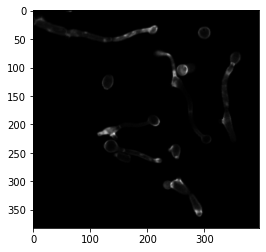

In [19]:
plt.imshow(img2[:,:,50], cmap='gray')
plt.show()

In [7]:
def rotation_matrix(a, b, g, x_t, y_t, z_t):
    A = np.array([[np.cos(a)*np.cos(b), np.cos(a)*np.sin(b)*np.sin(g)-np.sin(a)*np.cos(g),np.cos(a)*np.sin(b)*np.cos(g)+np.sin(a)*np.sin(g), x_t],
                  [np.sin(a)*np.cos(b), np.sin(a)*np.sin(b)*np.sin(g)+np.cos(a)*np.cos(g),np.sin(a)*np.sin(b)*np.cos(g)-np.cos(a)*np.sin(g), y_t],
                  [-np.sin(b), np.cos(b)*np.sin(g), np.cos(b)*np.cos(g), z_t],
                  [0, 0, 0, 1]])
    return np.linalg.inv(A)

In [8]:
def rotated_plane(img, a, b, g, x_t, y_t, z_t, interpolation = 'nearest', load = True):
    rot = rotation_matrix(a, b, g, x_t, y_t, z_t)

    count = 0
    p_x, p_y, p_z = img.shape[0]//2, img.shape[1]//2, img.shape[2]//2
    
    if not load:
        indices = np.zeros((4, img.shape[0]*img.shape[1]*img.shape[2]), dtype=np.float16)
        for i in tqdm(range(img.shape[0])):
            for j in range(img.shape[1]):
                for k in range(img.shape[2]):
                    indices[:, count] = [i-p_x, j-p_y, k-p_z, 1]
                    count += 1
        with open('indices.pkl', 'wb') as file:
            pkl.dump(indices, file)
    else:
        with open('indices.pkl', 'rb') as file:
            indices = pkl.load(file)
    indices = rot @ indices
    indices = indices + np.array([[p_x, p_y, p_z, 0]]).T
    del rot 
    indices = indices.T[:, 0:3]
    
    
    return interpn((np.arange(img.shape[0]),np.arange(img.shape[1]),np.arange(img.shape[2])), img, indices, 
    method= interpolation, bounds_error=False, fill_value=0).reshape(img2.shape)
                    
                

In [9]:
new = rotated_plane(img2,math.pi, 0.3, 0.2, 0, 0, 0, 'linear', False)

100%|██████████| 764/764 [01:13<00:00, 10.42it/s]


: 

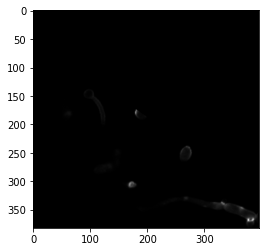

In [29]:
plt.imshow(new[:,:,50], cmap='gray')

In [ ]:
new = new[new>0.5]*1


In [ ]:
print(new)

In [ ]:
plt.imshow(new[:,:,50], cmap='gray')
plt.show()

In [ ]:
rot = rotation_matrix(0, 0, 0, 0, 0, 0)
indexes = np.zeros((4, img2.shape[0]*img2.shape[1]*img2.shape[2]), dtype=np.int16)
values = np.zeros((img2.shape[0]*img2.shape[1]*img2.shape[2]))
count = 0
for i in tqdm(range(img2.shape[0])):
    for j in range(img2.shape[1]):
        for k in range(img2.shape[2]):
            indexes[:, count] = [i,j,k,1]
            values[count] = img2[i,j,k]
            count += 1
indexes2 = rot @ indexes






In [ ]:
indexes2 = indexes2.T[:, 0:3]
print(indexes2.shape)

In [ ]:
new_img = np.zeros(img2.shape)
x = np.arange(120)
y = np.arange(120)
z = np.arange(120)
points = (x,y,z)
values = img2

new_img = interpn(points, values, indexes2, method='nearest', bounds_error=False, fill_value=0).reshape(img2.shape)




In [ ]:
print(new_img.shape)

In [ ]:
plt.imshow(new_img[:,:,50], cmap='gray')

In [ ]:
rot = rotation_matrix(math.pi, 0.3, 0.2, 0, 0, 0)

with open('indices.pkl', 'rb') as file:
    indices = pkl.load(file)
indices2 = rot @ indices

interpolated = interpn(indices[:,:-1], img2, indices2, method='nearest', bounds_error=False, fill_value=0)

In [ ]:
ind = np.indices(img2)


In [ ]:
print(img2.shape)

In [ ]:
plt.imshow(img2[:,:,50], cmap='gray')

In [ ]:


# interpolated = interpn(A, img2, indexes2[:-1,:], method='linear', bounds_error=False, fill_value=0)

In [ ]:
rot = rotation_matrix(0, 0, 0, 0, 0, 0)
indexes2 = rot @ indexes
x = np.linspace(0, 120, 120)
y = np.linspace(0, 120, 120)
z = np.linspace(0, 120, 120)
points = (x,y,z)
interpolated = interpn(points, img2, indexes2[:-1,:].T, method='nearest', bounds_error=False, fill_value=1)


In [ ]:
new_img = np.zeros(img2.shape)
counter = 0
for i in tqdm(range(img2.shape[0])):
    for j in range(img2.shape[1]):
        for k in range(img2.shape[2]):
            new_img[i,j,k] = interpolated[counter]
            counter += 1

In [ ]:
print(new_img.shape)

In [ ]:

plt.imshow(new_img[:,:,100], cmap='gray')
plt.show()

In [ ]:
plt.imshow(img2[:,:,100], cmap='gray')
plt.show()

In [ ]:
print(indexes.shape)
print(indexes2.shape)

In [ ]:
print(img2.shape)